### import modules

In [1]:
import h5py, os, nilearn
import matplotlib.pyplot as plt
import numpy as np
#from nilearn import input_data, datasets, plotting
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
from nltools.stats import isc, threshold, fdr
from tqdm import tqdm
import pandas as pd
import re

### define Filenames

In [25]:
file_paths = ["./fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5",
              "./fmri/sub-02/func/sub-02_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5",
              "./fmri/sub-03/func/sub-03_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5",
              "./fmri/sub-05/func/sub-05_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"]


sub_names = ['sub-01',
             'sub-02',
             'sub-03',
             'sub-05' ]

# NOTE: most, but not all Friends episodes were presented according to the series order 
#(for example, fMRI responses for episode 1 of season 1 were collected during the second or third recording session).
# MISSING fMRI DATA:
# Subject 2 is missing s05e20a.
# Subject 5 is missing s04e01a, s04e01b and s04e13b.

season01 = ['ses-001_task-s01e02a',
            'ses-001_task-s01e02b',
            'ses-001_task-s01e03a',
            'ses-001_task-s01e03b',
            'ses-002_task-s01e04a',
            'ses-002_task-s01e04b',
            'ses-002_task-s01e05a',
            'ses-002_task-s01e05b',
            'ses-003_task-s01e01a',
            'ses-003_task-s01e01b',
            'ses-003_task-s01e06a',
            'ses-003_task-s01e06b',
            'ses-004_task-s01e07a',
            'ses-004_task-s01e07b',
            'ses-004_task-s01e08a',
            'ses-004_task-s01e08b',
            'ses-004_task-s01e09a',
            'ses-004_task-s01e09b',
            'ses-005_task-s01e10a',
            'ses-005_task-s01e10b',
            'ses-005_task-s01e11a',
            'ses-005_task-s01e11b',
            'ses-006_task-s01e12a',
            'ses-006_task-s01e12b',
            'ses-006_task-s01e13a',
            'ses-006_task-s01e13b',
            'ses-006_task-s01e14a',
            'ses-006_task-s01e14b',
            'ses-007_task-s01e15a',
            'ses-007_task-s01e15b',
            'ses-007_task-s01e16a',
            'ses-007_task-s01e16b',
            'ses-007_task-s01e17a',
            'ses-007_task-s01e17b',
            'ses-008_task-s01e18a',
            'ses-008_task-s01e18b',
            'ses-008_task-s01e19a',
            'ses-008_task-s01e19b',
            'ses-009_task-s01e20a',
            'ses-009_task-s01e20b',
            'ses-009_task-s01e21a',
            'ses-009_task-s01e21b',
            'ses-009_task-s01e22a',
            'ses-009_task-s01e22b',
            'ses-010_task-s01e23a',
            'ses-010_task-s01e23b',
            'ses-010_task-s01e24a',
            'ses-010_task-s01e24b']
            
season02 = ['ses-010_task-s02e01a',
            'ses-010_task-s02e01b',
            'ses-011_task-s02e02a',
            'ses-011_task-s02e02b',
            'ses-011_task-s02e03a',
            'ses-011_task-s02e03b',
            'ses-011_task-s02e04a',
            'ses-011_task-s02e04b',
            'ses-011_task-s02e05a',
            'ses-011_task-s02e05b',
            'ses-012_task-s02e06a',
            'ses-012_task-s02e06b',
            'ses-012_task-s02e07a',
            'ses-012_task-s02e07b',
            'ses-013_task-s02e08a',
            'ses-013_task-s02e08b',
            'ses-013_task-s02e09a',
            'ses-013_task-s02e09b',
            'ses-013_task-s02e10a',
            'ses-013_task-s02e10b',
            'ses-014_task-s02e11a',
            'ses-014_task-s02e11b',
            'ses-014_task-s02e12a',
            'ses-014_task-s02e12b',
            'ses-014_task-s02e13a',
            'ses-014_task-s02e13b',
            'ses-015_task-s02e14a',
            'ses-015_task-s02e14b',
            'ses-015_task-s02e15a',
            'ses-015_task-s02e15b',
            'ses-016_task-s02e16a',
            'ses-016_task-s02e16b',
            'ses-016_task-s02e17a',
            'ses-016_task-s02e17b',
            'ses-017_task-s02e18a',
            'ses-017_task-s02e18b',
            'ses-017_task-s02e19a',
            'ses-017_task-s02e19b',
            'ses-017_task-s02e20a',
            'ses-017_task-s02e20b',
            'ses-017_task-s02e21a',
            'ses-017_task-s02e21b',
            'ses-017_task-s02e22a',
            'ses-017_task-s02e22b',
            'ses-018_task-s02e23a',
            'ses-018_task-s02e23b',
            'ses-018_task-s02e24a',
            'ses-018_task-s02e24b']
                     
      
season03 = [ 'ses-019_task-s03e01a',
            'ses-019_task-s03e01b',
            'ses-019_task-s03e02a',
            'ses-019_task-s03e02b',
            'ses-019_task-s03e03a',
            'ses-019_task-s03e03b',
            'ses-020_task-s03e04a',
            'ses-020_task-s03e04b',
            'ses-020_task-s03e05a',
            'ses-020_task-s03e05b',
            'ses-020_task-s03e06a',
            'ses-020_task-s03e06b',
            'ses-021_task-s03e07a',
            'ses-021_task-s03e07b',
            'ses-021_task-s03e08a',
            'ses-021_task-s03e08b',
            'ses-021_task-s03e09a',
            'ses-021_task-s03e09b',
            'ses-022_task-s03e10a',
            'ses-022_task-s03e10b',
            'ses-022_task-s03e11a',
            'ses-022_task-s03e11b',
            'ses-022_task-s03e12a',
            'ses-022_task-s03e12b',
            'ses-023_task-s03e13a',
            'ses-023_task-s03e13b',
            'ses-023_task-s03e14a',
            'ses-023_task-s03e14b',
            'ses-024_task-s03e15a',
            'ses-024_task-s03e15b',
            'ses-024_task-s03e16a',
            'ses-024_task-s03e16b',
            'ses-024_task-s03e17a',
            'ses-024_task-s03e17b',
            'ses-025_task-s03e18a',
            'ses-025_task-s03e18b',
            'ses-025_task-s03e19a',
            'ses-025_task-s03e19b',
            'ses-025_task-s03e20a',
            'ses-025_task-s03e20b',
            'ses-026_task-s03e21a',
            'ses-026_task-s03e21b',
            'ses-026_task-s03e22a',
            'ses-026_task-s03e22b',
            'ses-027_task-s03e23a',
            'ses-027_task-s03e23b',
            'ses-027_task-s03e24a',
            'ses-027_task-s03e24b',
            'ses-027_task-s03e25a',
            'ses-027_task-s03e25b']
                    
season04 = [ #'ses-027_task-s04e01a',   # Subject 5 is missing s04e01a, s04e01b and s04e13b.
            #'ses-027_task-s04e01b',
            'ses-027_task-s04e02a',
            'ses-027_task-s04e02b',
            'ses-028_task-s04e03a',
            'ses-028_task-s04e03b',
            'ses-028_task-s04e04a',
            'ses-028_task-s04e04b',
            'ses-028_task-s04e05a',
            'ses-028_task-s04e05b',
            'ses-028_task-s04e06a',
            'ses-028_task-s04e06b',
            'ses-028_task-s04e07a',
            'ses-028_task-s04e07b',
            'ses-029_task-s04e08a',
            'ses-029_task-s04e08b',
            'ses-029_task-s04e09a',
            'ses-029_task-s04e09b',
            'ses-029_task-s04e10a',
            'ses-029_task-s04e10b',
            'ses-029_task-s04e11a',
            'ses-029_task-s04e11b',
            'ses-030_task-s04e12a',
            'ses-030_task-s04e12b',
            #'ses-030_task-s04e13a',
            #'ses-030_task-s04e13b',
            'ses-030_task-s04e14a',
            'ses-030_task-s04e14b',
            'ses-031_task-s04e15a',
            'ses-031_task-s04e15b',
            'ses-031_task-s04e16a',
            'ses-031_task-s04e16b',
            'ses-031_task-s04e17a',
            'ses-031_task-s04e17b',
            'ses-032_task-s04e18a',
            'ses-032_task-s04e18b',
            'ses-032_task-s04e19a',
            'ses-032_task-s04e19b',
            'ses-033_task-s04e20a',
            'ses-033_task-s04e20b',
            'ses-034_task-s04e21a',
            'ses-034_task-s04e21b',
            'ses-034_task-s04e22a',
            'ses-034_task-s04e22b',
            'ses-035_task-s04e23a',
            'ses-035_task-s04e23b',
            'ses-035_task-s04e23c',
            'ses-035_task-s04e23d']

season05 = ['ses-036_task-s05e01a',
            'ses-036_task-s05e01b',
            'ses-036_task-s05e02a',
            'ses-036_task-s05e02b',
            'ses-037_task-s05e03a',
            'ses-037_task-s05e03b',
            'ses-037_task-s05e04a',
            'ses-037_task-s05e04b',
            'ses-041_task-s05e05a',
            'ses-041_task-s05e05b',
            'ses-041_task-s05e06a',
            'ses-041_task-s05e06b',
            'ses-042_task-s05e07a',
            'ses-042_task-s05e07b',
            'ses-043_task-s05e08a',
            'ses-043_task-s05e08b',
            'ses-044_task-s05e09a',
            'ses-044_task-s05e09b',
            'ses-044_task-s05e10a',
            'ses-044_task-s05e10b',
            'ses-045_task-s05e11a',
            'ses-045_task-s05e11b',
            'ses-045_task-s05e12a',
            'ses-045_task-s05e12b',
            'ses-046_task-s05e13a',
            'ses-046_task-s05e13b',
            'ses-046_task-s05e14a',
            'ses-046_task-s05e14b',
            'ses-047_task-s05e15a',
            'ses-047_task-s05e15b',
            'ses-047_task-s05e16a',
            'ses-047_task-s05e16b',
            'ses-048_task-s05e17a',
            'ses-048_task-s05e17b',
            'ses-048_task-s05e18a',
            'ses-048_task-s05e18b',
            'ses-049_task-s05e19a',
            'ses-049_task-s05e19b',
            #'ses-049_task-s05e20a',   # Subject 2 is missing s05e20a.
            #'ses-049_task-s05e20b',
            'ses-050_task-s05e21a',
            'ses-050_task-s05e21b',
            'ses-050_task-s05e22a',
            'ses-050_task-s05e22b',
            'ses-051_task-s05e23a',
            'ses-051_task-s05e23b',
            'ses-052_task-s05e23c',
            'ses-052_task-s05e23d']
            
season06 = ['ses-052_task-s06e01a',
            'ses-052_task-s06e01b',
            'ses-053_task-s06e02a',
            'ses-053_task-s06e02b',
            #'ses-053_task-s06e03a',  #also absent for one
            #'ses-053_task-s06e03b',
            'ses-053_task-s06e04a',
            'ses-054_task-s06e04b',
            'ses-054_task-s06e05a',
            'ses-054_task-s06e05b',
            'ses-055_task-s06e06a',
            'ses-055_task-s06e06b',
            'ses-055_task-s06e07a',
            'ses-055_task-s06e07b',
            'ses-056_task-s06e08a',
            'ses-056_task-s06e08b',
            'ses-056_task-s06e09a',
            'ses-056_task-s06e09b',
            'ses-056_task-s06e10a',
            'ses-057_task-s06e10b',
            'ses-057_task-s06e11a',
            'ses-057_task-s06e11b',
            'ses-057_task-s06e12a',
            'ses-057_task-s06e12b',
            'ses-058_task-s06e13a',
            'ses-058_task-s06e13b',
            'ses-058_task-s06e14a',
            'ses-058_task-s06e14b',
            'ses-059_task-s06e15a',
            'ses-060_task-s06e15b',
            'ses-060_task-s06e15c',
            'ses-061_task-s06e15d',
            'ses-061_task-s06e17a',
            'ses-061_task-s06e17b',
            'ses-062_task-s06e18a',
            'ses-062_task-s06e18b',
            'ses-062_task-s06e19a',
            'ses-062_task-s06e19b',
            'ses-063_task-s06e20a',
            'ses-063_task-s06e20b',
            'ses-063_task-s06e21a',
            'ses-064_task-s06e21b',
            'ses-064_task-s06e22a',
            'ses-064_task-s06e22b',
            'ses-065_task-s06e23a',
            'ses-065_task-s06e23b',
            #'ses-065_task-s06e24a',
            #'ses-066_task-s06e24b'
            #'ses-066_task-s06e24c',
            #'ses-066_task-s06e24d'
           ]

season_list = [season01, 
               season02, 
               season03, 
               season04, 
               season05, 
               season06 ]

outpath = './fmri/seasons/'

In [26]:
for current_season in season_list:
    #print(current_season)
    
    for current_session in current_season:
        print(current_session)
        
        data = []
        for current_sub_index in range(len(sub_names)):
        
            current_path = file_paths[current_sub_index]
            #print(current_path)
            
            current_subject = sub_names[current_sub_index]
            #print(current_subject)
            
            with h5py.File(current_path, "r") as h5_file:
            
                        match = re.match(r"ses-\d{3}(_task-.*)", current_session)
                        task_part = match.group(1)  # Extracts '_task-s01e02a' part
                        matching_keys = [key for key in h5_file.keys() if key.endswith(task_part)]
                        selected_key = matching_keys[0]
                        curr_data = h5_file[selected_key][:];
                
            print(task_part[1:])
            #print(curr_data.shape)
            data.append(curr_data)
        data = np.asarray(data)
        print(data.shape)
        current_outname = outpath   + task_part[1:]
        #print(current_outname)
        np.save(current_outname, data)
        print('# # #')
        print('=========================================')

ses-001_task-s01e02a
task-s01e02a
task-s01e02a
task-s01e02a
task-s01e02a
(4, 482, 1000)
# # #
ses-001_task-s01e02b
task-s01e02b
task-s01e02b
task-s01e02b
task-s01e02b
(4, 482, 1000)
# # #
ses-001_task-s01e03a
task-s01e03a
task-s01e03a
task-s01e03a
task-s01e03a
(4, 472, 1000)
# # #
ses-001_task-s01e03b
task-s01e03b
task-s01e03b
task-s01e03b
task-s01e03b
(4, 472, 1000)
# # #
ses-002_task-s01e04a
task-s01e04a
task-s01e04a
task-s01e04a
task-s01e04a
(4, 503, 1000)
# # #
ses-002_task-s01e04b
task-s01e04b
task-s01e04b
task-s01e04b
task-s01e04b
(4, 503, 1000)
# # #
ses-002_task-s01e05a
task-s01e05a
task-s01e05a
task-s01e05a
task-s01e05a
(4, 468, 1000)
# # #
ses-002_task-s01e05b
task-s01e05b
task-s01e05b
task-s01e05b
task-s01e05b
(4, 468, 1000)
# # #
ses-003_task-s01e01a
task-s01e01a
task-s01e01a
task-s01e01a
task-s01e01a
(4, 592, 1000)
# # #
ses-003_task-s01e01b
task-s01e01b
task-s01e01b
task-s01e01b
task-s01e01b
(4, 592, 1000)
# # #
ses-003_task-s01e06a
task-s01e06a
task-s01e06a
task-s01e06a


In [28]:
data.shape

(4, 520, 1000)

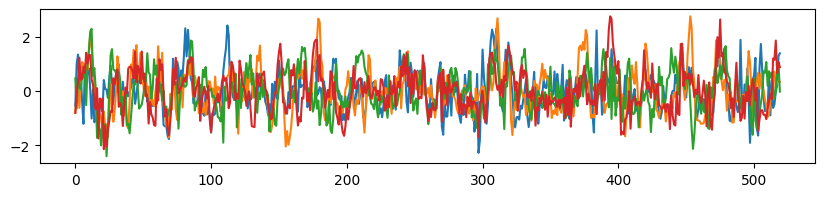

In [36]:
plt.figure(figsize = (10,2))
plt.plot(data[0,:,580]);
plt.plot(data[1,:,580]);
plt.plot(data[2,:,580]);
plt.plot(data[3,:,580]);